In [45]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%reload_ext autoreload
%autoreload 2

# <span style='color:lightgreen'>Logs

In [48]:
model_id = 'BBall'
model = 'LSTransformer'
input_features = 'P'
lt_logs_df = pd.read_csv('./logs/long_term_forecast.csv', index_col = 0)
query = (lt_logs_df['model_id'] == model_id)&(lt_logs_df['inverse'])#&(lt_logs_df['model'] == model)#&(lt_logs_df['input_features'] == input_features)
lt_logs_df[query][['model', 'data','seq_len', 'pred_len', 'lstm_layers','e_layers','d_model', 'd_layers', 'd_fc',
       'dropout', 'learning_rate', 'train_epochs','epoch','nb_params', 'rmse','mse', 'mae']].sort_values('rmse')#.head(10)

,model,data,seq_len,pred_len,lstm_layers,e_layers,d_model,d_layers,d_fc,dropout,learning_rate,train_epochs,epoch,nb_params,rmse,mse,mae
123,LSTransformer,BBall,24,24,2,2,256,1,128,0.10,0.001,36,NaN,3617944,5.097222,25.981676,3.389204
111,LSTransformer,BBall,24,24,2,1,256,1,128,0.10,0.001,24,NaN,2302872,5.126543,26.281437,3.424710
150,SABFormer,BBall,24,24,2,4,512,1,512,0.10,0.001,36,NaN,40666136,5.158598,26.611132,3.458703
149,SABFormer,BBall,24,24,2,4,256,1,256,0.10,0.001,36,NaN,10830360,5.168597,26.714397,3.479085
147,SABFormer,BBall,24,24,2,3,512,1,512,0.10,0.001,36,NaN,31208984,5.198474,27.024136,3.525517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,SABFormer,BBall,24,24,2,1,64,1,64,0.25,0.001,36,NaN,475992,8.055940,64.898170,6.281635
89,Nonstationary_Transformer,BBall,24,24,1,4,128,2,128,0.25,0.001,24,NaN,5058342,8.256388,68.167931,5.628137
125,SABFormer,BBall,24,24,2,1,64,2,64,0.25,0.001,36,NaN,480280,8.276253,68.496361,6.536339
91,LSTransformer,BBall,24,24,1,4,128,2,128,0.25,0.001,24,NaN,2734744,10.690101,114.278252,8.180581


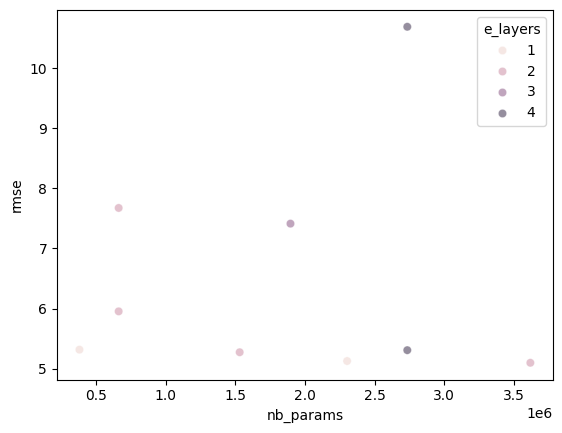

In [47]:
sns.scatterplot( data = lt_logs_df[query], 
                x = 'nb_params', y='rmse', alpha = 0.5,
                hue= 'e_layers');
                #hue= 'model');

In [5]:
st_logs_df = pd.read_csv('./logs/short_term_forecast.csv', index_col = 0)
st_logs_df[['model', 'seasonal_patterns','data', 'seq_len', 'pred_len', 'c_out', 'd_model', 'n_heads', 'e_layers', 'd_layers', 'd_ff',
       'moving_avg', 'dropout', 'learning_rate', 'avg_smape', 'avg_mase', 'avg_owa', 'avg_mape']]

,model,seasonal_patterns,data,seq_len,pred_len,c_out,d_model,n_heads,e_layers,d_layers,d_ff,moving_avg,dropout,learning_rate,avg_smape,avg_mase,avg_owa,avg_mape
0,LSTransformer,Monthly,m4,36,18,1,128,16,1,1,2048,25,0.25,0.001,85.159,18.813,8.059,66.652
1,LSTransformer,Yearly,m4,12,6,1,128,16,1,1,2048,25,0.25,0.001,85.159,18.813,8.059,66.652
2,LSTransformer,Quarterly,m4,16,8,1,128,16,1,1,2048,25,0.25,0.001,85.159,18.813,8.059,66.652
3,LSTransformer,Weekly,m4,26,13,1,128,16,1,1,2048,25,0.25,0.001,85.159,18.813,8.059,66.652
4,LSTransformer,Daily,m4,28,14,1,128,16,1,1,2048,25,0.25,0.001,85.159,18.813,8.059,66.652
5,LSTransformer,Hourly,m4,96,48,1,128,16,1,1,2048,25,0.25,0.001,85.159,18.813,8.059,66.652
6,TimesNet,Hourly,m4,96,48,1,32,8,2,1,32,25,0.10,0.001,11.920,1.598,0.857,14.017
7,Nonstationary_Transformer,Hourly,m4,96,48,1,512,8,2,1,2048,25,0.10,0.001,NaN,NaN,NaN,NaN


# <span style = 'color:lightblue'> Model

In [ ]:
from types import SimpleNamespace
configs = SimpleNamespace(**lt_logs_df.loc[21].to_dict())
configs.model

'LSTransformer'

In [ ]:
from models.LSTransformer import Model
from utils.model_wrapper import ModelWrapper
model = ModelWrapper(Model(configs=configs), configs)
model.summary()

Model quick summary
Layer name                    |          Nb units|      Nb tr params|  Nb non tr params
LSTM_0                        |               256|           271 360|                 0
Linear_0                      |               256|             2 048|                 0
LayerNorm_0                   |                 -|               512|                 0
Linear_1                      |               128|            32 896|                 0
TransformerEncoderLayer_0     |               128|           593 024|                 0
Linear_2                      |               256|            33 024|                 0
LayerNorm_1                   |                 -|               512|                 0
Linear_3                      |               336|            86 352|                 0
Skip_connections : True
Transformer_nb_heads : 8
Transformer_FF_units : 2048
Dropout_rate : p = 0.5

Nb trainable parameters : 1 019 728
Nb non-trainable parameters : 0
Total nb parameters